In [105]:
import os
import pandas as pd
import matplotlib.pyplot as plt


df_list = []
cleaned_filename_list = []
for filename in os.listdir("data/cleaned_data"):
    df = pd.read_csv(f"data/cleaned_data/{filename}")
    cleaned_filename_list.append(filename)
    df_list.append(df)
print(cleaned_filename_list)

['depth_resistance_65.csv', 'depth_resistance_68.csv', 'depth_resistance_6.csv', 'depth_resistance_78.csv', 'depth_resistance_43.csv', 'depth_resistance_37.csv', 'depth_resistance_29.csv', 'depth_resistance_58.csv', 'depth_resistance_30.csv', 'depth_resistance_36.csv', 'depth_resistance_12.csv', 'depth_resistance_66.csv', 'depth_resistance_76.csv', 'depth_resistance_24.csv', 'depth_resistance_4.csv', 'depth_resistance_38.csv', 'depth_resistance_22.csv', 'depth_resistance_48.csv', 'depth_resistance_11.csv', 'depth_resistance_62.csv', 'depth_resistance_42.csv', 'depth_resistance_34.csv', 'depth_resistance_54.csv', 'depth_resistance_69.csv', 'depth_resistance_35.csv', 'depth_resistance_73.csv', 'depth_resistance_40.csv', 'depth_resistance_61.csv', 'depth_resistance_17.csv', 'depth_resistance_0.csv', 'depth_resistance_53.csv', 'depth_resistance_20.csv', 'depth_resistance_56.csv', 'depth_resistance_33.csv', 'depth_resistance_23.csv', 'depth_resistance_72.csv', 'depth_resistance_55.csv', 'de

# Extract Feature: Peaks & Troughs

In [106]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def plot_peaks_troughs(df, peaks=[], troughs=[]):
    plt.figure(figsize=(4,3))         # Optional: set figure size
    # Plot the resistance curve
    plt.plot(df["depth"], df["resistance"])
    # Plot the peaks
    plt.plot(df["depth"].iloc[peaks], df["resistance"].iloc[peaks], 'ro', label="Peaks")
    # Plot the peaks
    plt.plot(df["depth"].iloc[troughs], df["resistance"].iloc[troughs], 'bo', label="Troughs")
    plt.xlabel("Depth")
    plt.ylabel("Resistance")
    plt.title("Depth vs Resistance with Peaks")
    plt.legend()
    plt.show()

def remove_peak_if_close_to_end(peaks, df):
    len_depth = len(df['depth'])
    cleaned_peaks = []
    for peak in peaks:
        if peak < len_depth * 0.6: cleaned_peaks.append(int(peak))
    return cleaned_peaks

def make_peak_bool(peaks):
    if len(peaks) > 0: return 1
    else: return 0

def get_yield_force(df):
    # Find peaks in the resistance data
    # distance -> req minimal horiz dis in samples between neighboring peaks 
    # # this is an excellent combination
    # peaks, _ = find_peaks(df["resistance"], height=0, distance=10, width=5)
    # peaks, _ = find_peaks(df["resistance"], distance=len(df["resistance"])*0.5, width=30)
    peaks, _ = find_peaks(df["resistance"], distance=100, width=20)
    
    peaks = remove_peak_if_close_to_end(peaks, df)
    troughs, _ = find_peaks(-df["resistance"], distance=200, width=20)    
    # plot_peaks_troughs(df, peaks, troughs)
    return peaks, troughs


# Choose Features

In [107]:
def extract_simple_features(df):
    res = df["resistance"]
    dep = df["depth"]
    peaks = find_peaks(df["resistance"], distance=30)[0]

    return pd.DataFrame({
        "res_mean": [res.mean()],
        # "peaks_value": peaks[0] if len(peaks) > 0 else 0,
        "overall_slope": [res.max() / dep.max()],
        "overall_depth": [dep.max()],
        "overall_resistance": [res.max()],
        # "num_peaks": len(peaks),
        # "heterogeneity": heterogeneity(df, surface_fraction=0.2)
    })

# shape (n,m) where n is number of df and m is extracted feaetures
representation_list = []
for i, df in enumerate(df_list):
    extracted_simple_features = extract_simple_features(df)
    representation_list.append(extracted_simple_features)
print(f"example: {representation_list[0]}")


example:     res_mean  overall_slope  overall_depth  overall_resistance
0  17.270592    1288.755764       0.021395           27.573464


# make a dataframe to map filenames parallel to all representations in representation_list
- i.e. filename_map_df.iloc[0] are the file names for representation_list[0]

In [108]:

filename_map = pd.read_csv("data/filename_mapping.csv")
uncleaned_filename_list = []
for i, filename in enumerate(cleaned_filename_list):
    uncleaned_filename = filename_map.loc[filename_map["cleaned_filenames"] == filename, 'uncleaned_filenames'].values[0]
    uncleaned_filename_list.append(uncleaned_filename)
filename_map_df = pd.DataFrame({
    'cleaned_filenames': cleaned_filename_list,
    'uncleaned_filenames': uncleaned_filename_list,
})
print(filename_map_df)

          cleaned_filenames  uncleaned_filenames
0   depth_resistance_65.csv  WS23_L3_T1_P_18.csv
1   depth_resistance_68.csv  WS23_L2_T1_P_17.csv
2    depth_resistance_6.csv  WS23_L1_T1_P_21.csv
3   depth_resistance_78.csv   WS23_L2_T1_P_7.csv
4   depth_resistance_43.csv  WS23_L3_T1_P_13.csv
..                      ...                  ...
75   depth_resistance_3.csv  WS23_L1_T1_P_17.csv
76  depth_resistance_67.csv  WS23_L3_T1_P_20.csv
77  depth_resistance_19.csv   WS23_L2_T1_P_6.csv
78  depth_resistance_70.csv   WS23_L1_T1_P_2.csv
79  depth_resistance_64.csv  WS23_L1_T1_P_19.csv

[80 rows x 2 columns]


# Correlation Matrix

In [109]:
representation_df  = pd.concat(representation_list, axis=0, ignore_index=True)
corr_matrix = representation_df.corr()
print(corr_matrix)

                    res_mean  overall_slope  overall_depth  overall_resistance
res_mean            1.000000       0.522720      -0.631149            0.840586
overall_slope       0.522720       1.000000      -0.662962            0.581636
overall_depth      -0.631149      -0.662962       1.000000           -0.832672
overall_resistance  0.840586       0.581636      -0.832672            1.000000


# Visualize Extracted Features Histograms

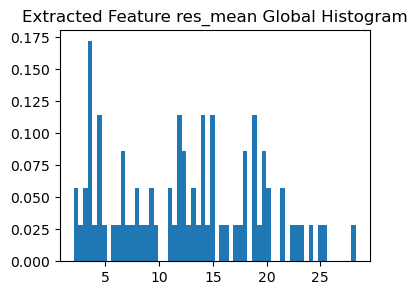

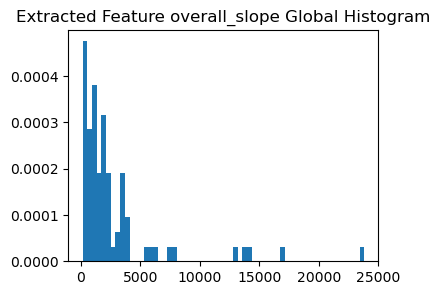

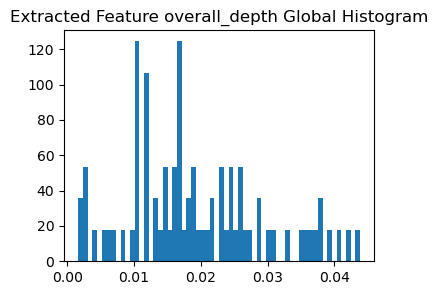

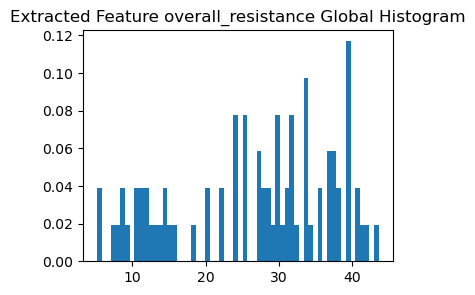

In [110]:
# representation_df  = pd.concat(representation_list, axis=0, ignore_index=True)
# # print(representation_df)
def plot_feature_dist(representation_df):
    for col in representation_df.columns:
        plt.figure(figsize=(4,3))
        plt.hist(representation_df[col], bins=60, density=True)
        plt.title(f"Extracted Feature {col} Global Histogram")
        plt.show()
plot_feature_dist(representation_df)

# Scale Features

   res_mean  overall_slope  overall_depth  overall_resistance
0  0.709976      -0.130390       0.209521            0.081697
1 -0.672055      -1.045555       1.365080           -1.053545
2 -1.218843       0.463150      -0.714387            0.288236
3 -1.410088      -1.872830       2.231655           -1.771156
4  0.030962       0.095832      -0.047660            0.412643


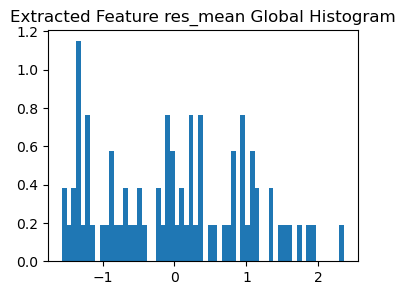

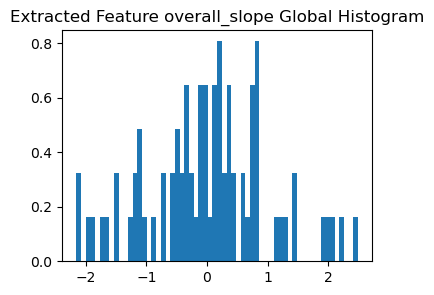

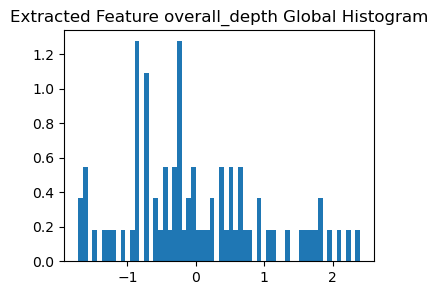

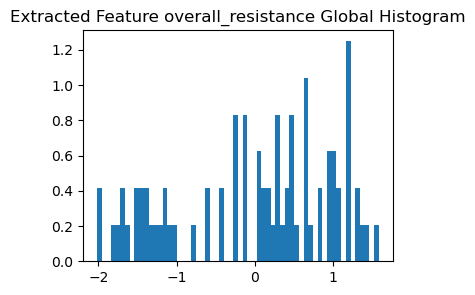

In [111]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def transform_features(df):
    df = df.copy()  # avoid modifying original
    # Apply cube root to 'slope'
    if "overall_slope" in df.columns: df['overall_slope'] = np.log(df['overall_slope'])
    if "peaks" in df.columns: df['peaks'] = np.log(df['peaks'] + 1)
    if "peaks_value" in df.columns: df["peaks_value"] = np.log(df['peaks_value'])
    # if "yield_force" in df.columns: df['yield_force'] = df["yield_force"]
    # if "skew" in df.columns: df["skew"] = df["skew"] ** 1.1
    # if "kurtosis" in df.columns: df["kurtosis"] = np.sqrt(df["kurtosis"]) 
    # Standardize
    scaler = StandardScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])
    return df

scaled_representations = transform_features(representation_df)
print(scaled_representations[:5])
plot_feature_dist(scaled_representations)


# Concat and Save representation

In [112]:
scaled_representations = pd.concat([scaled_representations, filename_map_df], axis=1)
scaled_representations.to_csv(f"data/features.csv", index=False)
print(scaled_representations)

    res_mean  overall_slope  overall_depth  overall_resistance  \
0   0.709976      -0.130390       0.209521            0.081697   
1  -0.672055      -1.045555       1.365080           -1.053545   
2  -1.218843       0.463150      -0.714387            0.288236   
3  -1.410088      -1.872830       2.231655           -1.771156   
4   0.030962       0.095832      -0.047660            0.412643   
..       ...            ...            ...                 ...   
75  1.712736       2.188703      -1.651172            1.221120   
76 -0.119566       0.770111      -0.857084            0.944077   
77 -1.258152      -1.474872       1.840031           -1.472376   
78 -1.389800      -1.302437       0.799018           -1.603459   
79 -0.929366      -1.078369       1.043905           -1.243667   

          cleaned_filenames  uncleaned_filenames  
0   depth_resistance_65.csv  WS23_L3_T1_P_18.csv  
1   depth_resistance_68.csv  WS23_L2_T1_P_17.csv  
2    depth_resistance_6.csv  WS23_L1_T1_P_21.csv  
3  